## 5.3 Задача - проверить метод анализа тестов над метриками-отношениями (linearized_likes)


У нас параллельно идут два теста.<br>
ПЕРВЫЙ:
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

ВТОРОЙ:
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

### Задача
1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?<br>
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?<br>

B 2018-м году исследователи из Яндекса разработали метод анализа тестов над метриками-отношениями.  <br>
##### Идея метода заключается в следующем: <br>     
Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR<br>
1. Считаем общий CTR в контрольной группе: 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) <br>
2. Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠 − 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 ∗ 𝑣𝑖𝑒𝑤𝑠 <br>
3. После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  <br>

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).<br>

In [ ]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

#для расчета доверительного интервала sms.DescrStatsW(df_group[column]).tconfint_mean()
import statsmodels.stats.api as sms 
import matplotlib.pyplot as plt
from scipy.stats import t

import warnings # игнорирую предупреждения системы об грядущих изменениях
warnings.simplefilter('ignore')

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20221020',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [4]:
# выгружаю данные из clickhouse в датафрейм
q = '''
SELECT  exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        (likes / views) as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-10-03' and '2022-10-09'
    AND exp_group in (0,1,2,3)
GROUP BY exp_group, user_id      
'''

df_new_metric = ph.read_clickhouse(q, connection = connection)

In [5]:
df_new_metric.groupby('exp_group', as_index = False).count()
#количество юзеров в каждой выборки приблизительно одинаковое

,exp_group,user_id,likes,views,ctr
0,0,9999,9999,9999,9999
1,1,10079,10079,10079,10079
2,2,9952,9952,9952,9952
3,3,10049,10049,10049,10049


In [6]:
# проверяю, чтобы один и тот же id не попал в разные группы 

print('Всего пользователей в 4 группах группах: ', df_new_metric.user_id.count())
print()
df_new_metric.uniq = df_new_metric.groupby('user_id')['exp_group'].nunique().reset_index()
df_new_metric.uniq.groupby('exp_group').user_id.count()

# каждый id попал только в 1 группу

Всего пользователей в 4 группах группах:  40079



exp_group
1    40079
Name: user_id, dtype: int64

In [7]:
#создала функцию для подсчета новой поюзерной метрики linearized_likes = 𝑙𝑖𝑘𝑒𝑠 − 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 ∗ 𝑣𝑖𝑒𝑤𝑠

def get_linearized_likes(user_likes, user_views, ctr_control):
    linearized_likes = user_likes - ctr_control * user_views
    return linearized_likes

In [8]:
# Считаем общий CTR в каждой группе
ctr_control_0 = df_new_metric[df_new_metric.exp_group == 0].likes.sum() / \
              df_new_metric[df_new_metric.exp_group == 0].views.sum()

ctr_control_1 = df_new_metric[df_new_metric.exp_group == 1].likes.sum() / \
              df_new_metric[df_new_metric.exp_group == 1].views.sum()

ctr_control_2 = df_new_metric[df_new_metric.exp_group == 2].likes.sum() / \
              df_new_metric[df_new_metric.exp_group == 2].views.sum()

ctr_control_3 = df_new_metric[df_new_metric.exp_group == 3].likes.sum() / \
              df_new_metric[df_new_metric.exp_group == 3].views.sum()

In [21]:
# общий CTR в каждой группе
ctr_control_0, ctr_control_1, ctr_control_2, ctr_control_3

(0.20823612262916305,
 0.20802680490126244,
 0.1980601844115994,
 0.22429590071006622)

In [22]:
# создала новые датафреймы по группам, чтобы потом посчитать в них поюзерную метрику linearized_likes
group_0 = df_new_metric[df_new_metric.exp_group == 0].copy()
group_1 = df_new_metric[df_new_metric.exp_group == 1].copy()
group_2 = df_new_metric[df_new_metric.exp_group == 2].copy()
group_3 = df_new_metric[df_new_metric.exp_group == 3].copy()

In [11]:
# рассчитываю поюзерную метрику linearized_likes для каждой группы
group_0['linearized_likes'] = group_0.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)
group_1['linearized_likes'] = group_1.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)
group_2['linearized_likes'] = group_2.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)
group_3['linearized_likes'] = group_3.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control_0), axis=1)

In [12]:
# сравниваю t-тестом отличия в группах по метрике ctr
# между группами 0 и 3 
stats.ttest_ind(df_new_metric[df_new_metric.exp_group == 0].ctr,
               df_new_metric[df_new_metric.exp_group == 3].ctr,
               equal_var = False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [13]:
# сравниваю t-тестом отличия в группах по метрике linearized_likes
# между группами 0 и 3 по метрике линеаризованных лайков
#pvalue стало намного меньше
stats.ttest_ind( group_0.linearized_likes,
               group_3.linearized_likes,
               equal_var = False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

<AxesSubplot:xlabel='ctr', ylabel='Density'>

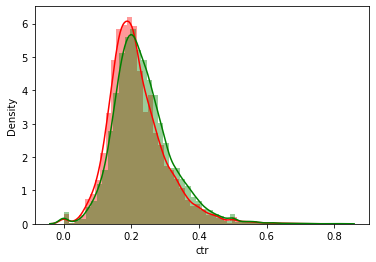

In [14]:
# строю график ctr для групп 0 и 3 
# распределения похожи на нормальное
sns.distplot(df_new_metric[df_new_metric.exp_group == 0].ctr, color= 'red')
sns.distplot(df_new_metric[df_new_metric.exp_group == 3].ctr, color= 'green')

<AxesSubplot:xlabel='linearized_likes', ylabel='Density'>

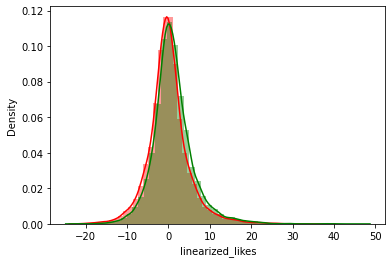

In [15]:
# строю график по метрике linearized_likes для групп 0 и 3 
# распределения похожи на нормальное
sns.distplot(group_0.linearized_likes, color= 'red')
sns.distplot(group_3.linearized_likes, color= 'green')

In [16]:
# сравниваю t-тестом отличия в группах по метрике ctr
# между группами 1 и 2 
# pvalue > 0.05
stats.ttest_ind(df_new_metric[df_new_metric.exp_group == 1].ctr,
               df_new_metric[df_new_metric.exp_group == 2].ctr,
               equal_var = False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [17]:
# сравниваю t-тестом отличия в группах по метрике linearized_likes
# между группами 1 и 2 по метрике линеаризованных лайков
# pvalue изменился и стал < 0.05
stats.ttest_ind(group_1.linearized_likes,
               group_2.linearized_likes,
               equal_var = False)

Ttest_indResult(statistic=6.1208039704412, pvalue=9.544973454280379e-10)

<AxesSubplot:xlabel='ctr', ylabel='Density'>

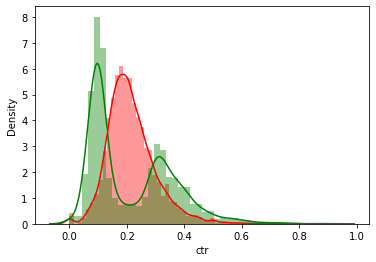

In [18]:
# строю график ctr для групп 1 и 2 
sns.distplot(df_new_metric[df_new_metric.exp_group == 1].ctr, color= 'red')
sns.distplot(df_new_metric[df_new_metric.exp_group == 2].ctr, color= 'green')

<AxesSubplot:xlabel='linearized_likes', ylabel='Density'>

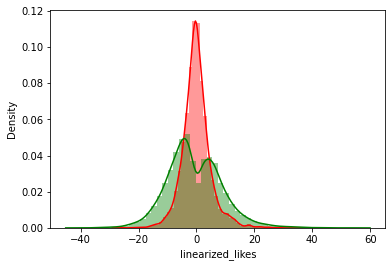

In [19]:
# строю график по метрике linearized_likes для групп 1 и 2 
sns.distplot(group_1.linearized_likes, color= 'red')
sns.distplot(group_2.linearized_likes, color= 'green')

In [20]:
# group_2.linearized_likes.describe()

### Вывод
1. С помощью t-теста были проанализированы метрики между группами 0 и 3: ctr и метрика линеаризованных лайков. 
* для CTR - pvalue изначально был < 0.05 <br>
* для метрики linearized_likes -pvalue < 0.05-  pvalue стал еще меньше, чем рассчитанный для CTR <br>

По результатам t-теста pvalue новой метрики linearized_likes стал намного меньше.<br>
Также на графике видим, что новая метрика linearized_likes имеет больший размах <br><br>


2. С помощью t-теста были проанализированы метрики между группами 1 и 2: ctr и метрика линеаризованных лайков. 
* для CTR - pvalue > 0.05 <br>
* для метрики linearized_likes - pvalue < 0.05 <br>

По результатам t-теста pvalue новой метрики linearized_likes стал намного меньше и стал менее 0.05.<br>
Также на графике видим, что новая метрика linearized_likes имеет больший размах. 
Кроме того, на графике видим, что распределение новой метрики, рассчитанное для тестовой группы 2 все также имеет 2 пика, однако просадка между пиками стала менее выражена. <br>


#### Линеаризация метрики привела к уменьшению pvalue в обоих тестах. По результатам обоих экспериментов, следует отвергнуть нулевую гипотезу и принять альтернативную.
